In [1]:
import numpy as np
import torch
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex=True)

import pandas as pd
import matplotlib.pyplot as plt

import urllib

In [2]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties("cuda"))
    print("Number of devices:",torch.cuda.device_count())
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

NVIDIA GeForce RTX 2080 Ti
_CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11011MB, multi_processor_count=68)
Number of devices: 1


In [3]:
# Setup URL to Data File
url = "https://raw.githubusercontent.com/luisroque/deep-learning-articles/main/data/eng-por.txt"

data = []
with urllib.request.urlopen(url) as raw_data:
    for line in raw_data:
        data.append(line.decode("utf-8").split('\t')[0:2])
data = np.array(data)

data.shape

In [4]:
# Subset? - All of the data will take some time...
n_seq = data.shape[0]
n_seq = 10000
data = data[0:n_seq]
split_point = int(data.shape[0] * 0.8) # Keep 80/20 split
np.random.shuffle(data) # In-place modification
max_length = np.max([len(i) for i in data.flatten()]) + 2 # Add start/stop

print(f"max_length = ${max_length}")
print(f"data[0] => ${data[0]}")

max_length = $45
data[0] => $['My eyes hurt.' 'Meus olhos doem.']


In [5]:
# Setup
i_to_c_eng = ['','<START>','<STOP>'] + list({char for word in data[:,0] for char in word})
c_to_i_eng = {i_to_c_eng[i]:i for i in range(len(i_to_c_eng))}
i_to_c_eng[1] = i_to_c_eng[2] = ''

i_to_c_por = ['','<START>','<STOP>'] + list({char for word in data[:,1] for char in word})
c_to_i_por = {i_to_c_por[i]:i for i in range(len(i_to_c_por))}
i_to_c_por[1] = i_to_c_por[2] = ''


In [16]:
def encode_seq(x, mapping, max_length=0):
    # String to integer
    return [mapping['<START>']] + \
    [mapping[i] for i in list(x)] + \
    [mapping['<STOP>']] + \
    [0]*(max_length-len(list(x))-2)
    
def decode_seq(x, mapping):
    # Integer-to-string
    try:
        idx = list(x).index(2) # Stop token?
    except:
        idx = len(list(x)) # No stop token found
    return ''.join([mapping[i] for i in list(x)[0:idx]])

In [17]:
data[0]


array(['My eyes hurt.', 'Meus olhos doem.'], dtype='<U184')

In [18]:
data[0,0]

'My eyes hurt.'

In [19]:
temp = encode_seq(data[0,0],c_to_i_eng,max_length)

print(temp)

[1, 25, 39, 61, 24, 39, 24, 12, 61, 48, 42, 70, 6, 67, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [20]:
decode_seq(temp, i_to_c_eng)

'My eyes hurt.'

In [21]:
data[0,1]

'Meus olhos doem.'

In [22]:
temp = encode_seq(data[0,1],c_to_i_por,max_length)

print(temp)

[1, 29, 71, 11, 26, 38, 57, 63, 13, 57, 26, 38, 76, 57, 71, 30, 19, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [23]:
decode_seq(temp, i_to_c_por)

'Meus olhos doem.'

In [24]:
# Setup
X = np.vstack([encode_seq(x, c_to_i_eng, max_length) for x in data[:,0]])
Y = np.vstack([encode_seq(x, c_to_i_por, max_length) for x in data[:,1]])

enc_x_train = X[:split_point]
enc_x_val = X[split_point:]
enc_x_train


array([[ 1, 25, 39, ...,  0,  0,  0],
       [ 1, 15, 60, ...,  0,  0,  0],
       [ 1, 59, 24, ...,  0,  0,  0],
       ...,
       [ 1, 15, 60, ...,  0,  0,  0],
       [ 1, 15, 61, ...,  0,  0,  0],
       [ 1, 15, 12, ...,  0,  0,  0]])

In [25]:
# Setup
dec_x_train = Y[:,0:-1][:split_point]
dec_x_val = Y[:,0:-1][split_point:]
dec_x_train

array([[ 1, 29, 71, ...,  0,  0,  0],
       [ 1, 17, 11, ...,  0,  0,  0],
       [ 1, 17, 26, ...,  0,  0,  0],
       ...,
       [ 1, 17, 11, ...,  0,  0,  0],
       [ 1, 17, 11, ...,  0,  0,  0],
       [ 1, 78, 42, ...,  0,  0,  0]])

In [26]:
dec_y_train = Y[:,1:][:split_point]
dec_y_val = Y[:,1:][split_point:]
dec_y_train

array([[29, 71, 11, ...,  0,  0,  0],
       [17, 11, 38, ...,  0,  0,  0],
       [17, 26, 23, ...,  0,  0,  0],
       ...,
       [17, 11, 38, ...,  0,  0,  0],
       [17, 11, 38, ...,  0,  0,  0],
       [78, 42, 11, ...,  0,  0,  0]])

In [27]:
print(enc_x_train.shape)
print(dec_x_train.shape)
print(dec_y_train.shape)

print("----")

print(enc_x_val.shape)
print(dec_x_val.shape)
print(dec_y_val.shape)

(8000, 45)
(8000, 44)
(8000, 44)
----
(2000, 45)
(2000, 44)
(2000, 44)


In [28]:
len(i_to_c_eng)

In [29]:
len(i_to_c_por)

In [30]:
enc_x_train.shape[1:]

In [117]:
class TransformerBlock(torch.nn.Module):
    def __init__(self,
                 latent_size = 64,
                 num_heads = 4,
                 dropout = 0.1,
                 **kwargs):
        super().__init__(**kwargs)
        self.layer_norm1 = torch.nn.LayerNorm(latent_size)
        self.layer_norm2 = torch.nn.LayerNorm(latent_size)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation = torch.nn.GELU()
        self.linear = torch.nn.Linear(latent_size,
                                      latent_size)
        self.mha = torch.nn.MultiheadAttention(latent_size,
                                               num_heads, 
                                               dropout=dropout,
                                               batch_first=True)
    
    def forward(self, x):
        y = x
        y = self.layer_norm1(y)
        y = self.mha(y, y, y)[0]
        x=y=x+y
        y = self.layer_norm2(y)
        y = self.linear(y)
        y = self.activation(y)
        return x +  y

class EncoderNetwork(torch.nn.Module):
    def __init__(self,
                 num_tokens,
                 max_length,
                 latent_size = 64,
                 num_heads = 4,
                 n_layers = 8,
                 **kwargs):
        super().__init__(**kwargs)
        self.token_embedding = torch.nn.Embedding(num_tokens,
                                                  latent_size,
                                                  padding_idx=0)
        self.position_embedding = torch.nn.Embedding(max_length+1,
                                                     latent_size,
                                                     padding_idx=0)
        self.transformer_blocks = torch.nn.Sequential(*[
            TransformerBlock(latent_size=latent_size,
                             num_heads=num_heads) for _ in range(n_layers)
        ])
        
    def forward(self, x):
        y = x
        y = self.token_embedding(y) + \
            self.position_embedding(torch.arange(1,y.shape[1]+1).long().to(device) * torch.sign(y).long().to(device))
        y = self.transformer_blocks(y)
        return y

In [118]:
enc_x_train[0:5].shape

In [119]:
enc_net = EncoderNetwork(num_tokens=len(i_to_c_eng), max_length=enc_x_train.shape[-1])

summary(enc_net,input_size=enc_x_train[0:5].shape,dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
EncoderNetwork                           [5, 45, 64]               --
├─Embedding: 1-1                         [5, 45, 64]               4,672
├─Embedding: 1-2                         [5, 45, 64]               2,944
├─Sequential: 1-3                        [5, 45, 64]               --
│    └─TransformerBlock: 2-1             [5, 45, 64]               --
│    │    └─LayerNorm: 3-1               [5, 45, 64]               128
│    │    └─MultiheadAttention: 3-2      [5, 45, 64]               16,640
│    │    └─LayerNorm: 3-3               [5, 45, 64]               128
│    │    └─Linear: 3-4                  [5, 45, 64]               4,160
│    │    └─GELU: 3-5                    [5, 45, 64]               --
│    └─TransformerBlock: 2-2             [5, 45, 64]               --
│    │    └─LayerNorm: 3-6               [5, 45, 64]               128
│    │    └─MultiheadAttention: 3-7      [5, 45, 64]               16

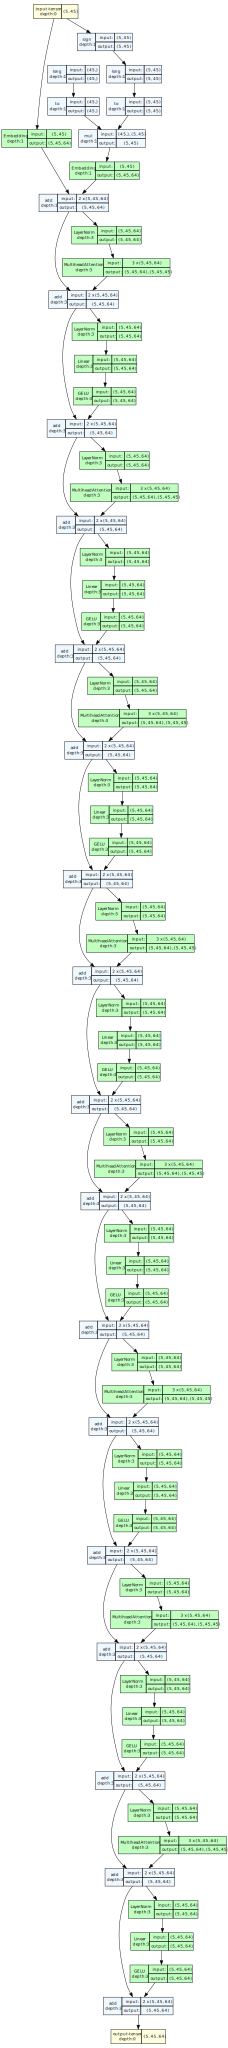

In [120]:
model_graph = draw_graph(enc_net,
                         input_data = torch.Tensor(enc_x_train[0:5]).long(),
                         device=device,
                         hide_inner_tensors=True,
                         hide_module_functions=True,
                         expand_nested=False,
                         depth=3,
                         dtypes=[torch.long])
model_graph.visual_graph

In [121]:
class MaskedTransformerBlock(torch.nn.Module):
    def __init__(self,
                 latent_size = 64, 
                 num_heads = 4, 
                 dropout = 0.1, 
                 **kwargs):
        super().__init__(**kwargs)
        self.layer_norm1 = torch.nn.LayerNorm(latent_size) 
        self.layer_norm2 = torch.nn.LayerNorm(latent_size) 
        self.layer_norm3 = torch.nn.LayerNorm(latent_size) 
        self.dropout = torch.nn.Dropout(dropout) 
        self.activation = torch.nn.GELU()
        self.linear = torch.nn.Linear(latent_size,
                                      latent_size)
        self.mha1 = torch.nn.MultiheadAttention(latent_size,
                                                num_heads, 
                                                dropout=dropout, 
                                                batch_first=True)
        self.mha2 = torch.nn.MultiheadAttention(latent_size, 
                                                num_heads,
                                                dropout=dropout, 
                                                batch_first=True)
    
    def make_causal_mask(self, sz: int):
        return torch.triu(torch.full((sz, sz), True), diagonal=1).to(device) 
        # return torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1)

    def forward(self, x):
        x_enc, x_dec = x
        x = y = x_dec
        y = self.layer_norm1(y)
        y = self.mha1(y,y,y,
                      attn_mask=self.make_causal_mask(y.shape[1]))[0]
        x = y = x + y
        y = self.layer_norm2(y)
        y = self.mha2(y, x_enc, x_enc)[0] 
        x = y = x + y
        y = self.layer_norm3(y)
        y = self.linear(y)
        y = self.activation(y)
        return x_enc, x + y

In [122]:
class DecoderNetwork(torch.nn.Module):
    def __init__(self,
                 num_tokens,
                 max_length, 
                 latent_size = 64, 
                 num_heads = 4, 
                 n_layers = 8,
                 **kwargs):
        super().__init__(**kwargs)
        self.token_embedding = torch.nn.Embedding(num_tokens,
                                                  latent_size,
                                                  padding_idx=0) 
        self.position_embedding = torch.nn.Embedding(max_length+1,
                                                     latent_size,
                                                     padding_idx=0) 
        self.transformer_blocks = torch.nn.Sequential(*[
            MaskedTransformerBlock(latent_size=latent_size,
                                   num_heads=num_heads) for _ in range(n_layers)
        ])
        self.output_layer = torch.nn.Linear(latent_size,
                                            num_tokens)

    def forward(self, x_enc, x_dec):
        y = x_dec
        y = self.token_embedding(y) + \
        self.position_embedding(torch.arange(1,y.shape[1]+1).long().to(device) * torch.sign(y).long().to(device))
        y = self.transformer_blocks((x_enc,y))[1]
        y = self.output_layer(y)
        return y

In [123]:
enc_x_train[0:5].shape

In [124]:
dec_x_train[0:5].shape

In [125]:
# Passed through the encoder network - output tensor shape for decoder
enc_net(torch.Tensor(enc_x_train[0:5]).long().to(device)).shape

torch.Size([5, 45, 64])

In [126]:
enc_x_train[0:5].shape[0:2]+(64,)

In [127]:
dec_net = DecoderNetwork(num_tokens=len(i_to_c_por), max_length=dec_x_train.shape[-1])

summary(dec_net,input_size=[enc_x_train[0:5].shape[0:2]+(64,),dec_x_train[0:5].shape], dtypes=[torch.float32, torch.long])

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Layer (type:depth-idx)                   Output Shape              Param #
DecoderNetwork                           [5, 44, 87]               --
├─Embedding: 1-1                         [5, 44, 64]               5,568
├─Embedding: 1-2                         [5, 44, 64]               2,880
├─Sequential: 1-3                        [5, 45, 64]               --
│    └─MaskedTransformerBlock: 2-1       [5, 45, 64]               --
│    │    └─LayerNorm: 3-1               [5, 44, 64]               128
│    │    └─MultiheadAttention: 3-2      [5, 44, 64]               16,640
│    │    └─LayerNorm: 3-3               [5, 44, 64]               128
│    │    └─MultiheadAttention: 3-4      [5, 44, 64]               16,640
│    │    └─LayerNorm: 3-5               [5, 44, 64]               128
│    │    └─Linear: 3-6                  [5, 44, 64]               4,160
│    │    └─GELU: 3-7                    [5, 44, 64]               --
│    └─MaskedTransformerBlock: 2-2       [5, 45, 64]             

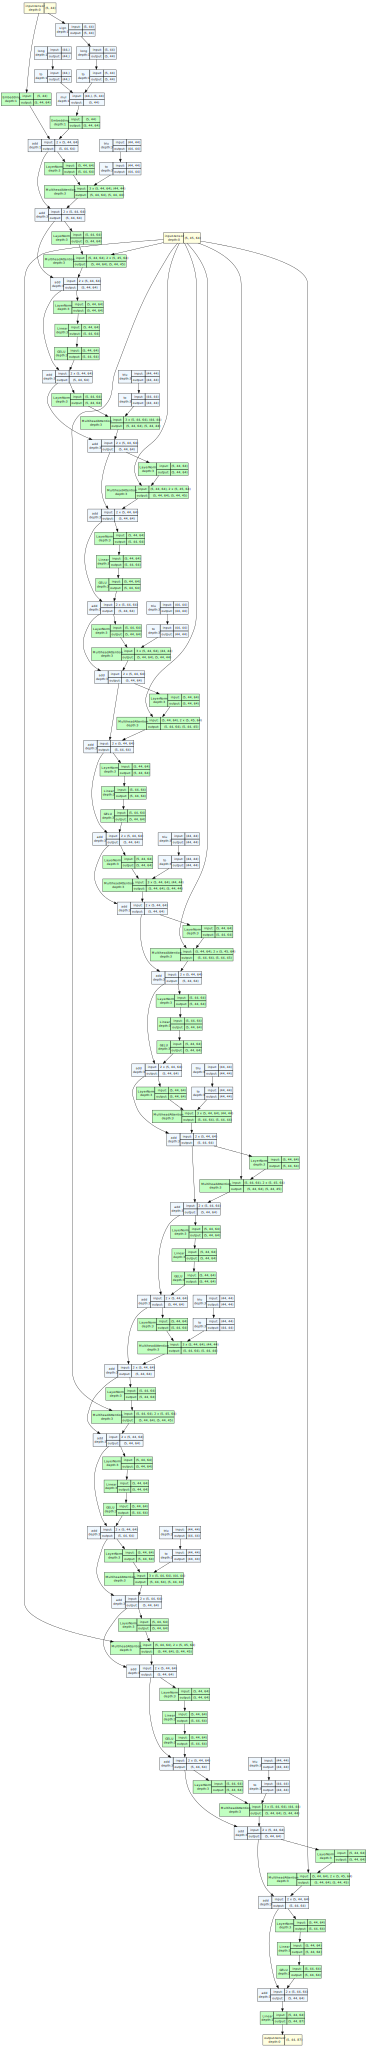

In [128]:
model_graph = draw_graph(dec_net,
                         input_data=[enc_net(torch.Tensor(enc_x_train[0:5]).long().to(device)), torch.Tensor(dec_x_train[0:5]).long()],
                         device=device,
                         hide_inner_tensors=True,
                         hide_module_functions=True,
                         expand_nested=False,
                         depth=3,
                         dtypes=[torch.long])

model_graph.visual_graph

In [129]:
class EncDecLightningModule(pl.LightningModule):
    def __init__(self,
                 output_size,
                 **kwargs):
        super().__init__(**kwargs)
        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass',
                                                           num_classes=output_size,
                                                           ignore_index=0)
        self.cce_loss = torch.nn.CrossEntropyLoss(ignore_index=0)

    def predict(self, x):
        return torch.softmax(self(x),-1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_enc, x_dec, y_dec = train_batch
        y_pred = self(x_enc, x_dec)
        perm = (0,-1) + tuple(range(y_pred.ndim))[1:-1]
        acc = self.mc_acc(y_pred.permute(*perm),y_dec)
        loss = self.cce_loss(y_pred.permute(*perm),y_dec)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    # Validate used for Teacher Forcing
    def validation_step(self, val_batch, batch_idx):
        x_enc, x_dec, y_dec = val_batch
        y_pred = self(x_enc, x_dec)
        perm = (0,-1) + tuple(range(y_pred.ndim))[1:-1]
        acc = self.mc_acc(y_pred.permute(*perm),y_dec)
        loss = self.cce_loss(y_pred.permute(*perm),y_dec)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    # Test used for Non-Teacher Forcing
    def test_step(self, test_batch, batch_idx):
        x_enc, x_dec, y_dec = test_batch
        context = self.enc_net(x_enc)
        tokens = torch.zeros_like(x_dec).long()
        tokens[:,0] = 1
        for i in range(y_dec.shape[1]-1):
            tokens[:,i+1] = self.dec_net(context, tokens).argmax(-1)[:,i]
        y_pred = self(x_enc, tokens)
        perm = (0,-1) + tuple(range(y_pred.ndim))[1:-1]
        acc = self.mc_acc(y_pred.permute(*perm),y_dec)
        loss = self.cce_loss(y_pred.permute(*perm),y_dec)
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss


In [130]:
class EncDecNetwork(EncDecLightningModule): 
    def __init__(self,
                 num_enc_tokens,
                 max_enc_length,
                 num_dec_tokens, 
                 max_dec_length, 
                 latent_size = 64,
                 num_heads = 4, 
                 n_layers = 8,
                 **kwargs):
        super().__init__(output_size=num_dec_tokens, 
                         **kwargs)
        self.enc_net = EncoderNetwork(num_enc_tokens, max_enc_length, latent_size, num_heads, n_layers) 
        self.dec_net = DecoderNetwork(num_dec_tokens, max_dec_length, latent_size, num_heads, n_layers)

    def forward(self, x_enc, x_dec):
        return self.dec_net(self.enc_net(x_enc), x_dec)



                                                         

In [132]:
enc_dec_net = EncDecNetwork(num_enc_tokens=len(i_to_c_eng), 
                            max_enc_length=enc_x_train.shape[-1],
                            num_dec_tokens=len(i_to_c_por), 
                            max_dec_length=dec_x_train.shape[-1], 
                            latent_size=64,
                            n_layers=4)

summary(enc_dec_net, input_size=[enc_x_train[0:1].shape, 
                                 dec_x_train[0:1].shape], 
        dtypes=[torch.long, torch.long])

Layer (type:depth-idx)                        Output Shape              Param #
EncDecNetwork                                 [1, 44, 87]               --
├─EncoderNetwork: 1-1                         [1, 45, 64]               --
│    └─Embedding: 2-1                         [1, 45, 64]               4,672
│    └─Embedding: 2-2                         [1, 45, 64]               2,944
│    └─Sequential: 2-3                        [1, 45, 64]               --
│    │    └─TransformerBlock: 3-1             [1, 45, 64]               21,056
│    │    └─TransformerBlock: 3-2             [1, 45, 64]               21,056
│    │    └─TransformerBlock: 3-3             [1, 45, 64]               21,056
│    │    └─TransformerBlock: 3-4             [1, 45, 64]               21,056
├─DecoderNetwork: 1-2                         [1, 44, 87]               --
│    └─Embedding: 2-4                         [1, 44, 64]               5,568
│    └─Embedding: 2-5                         [1, 44, 64]             

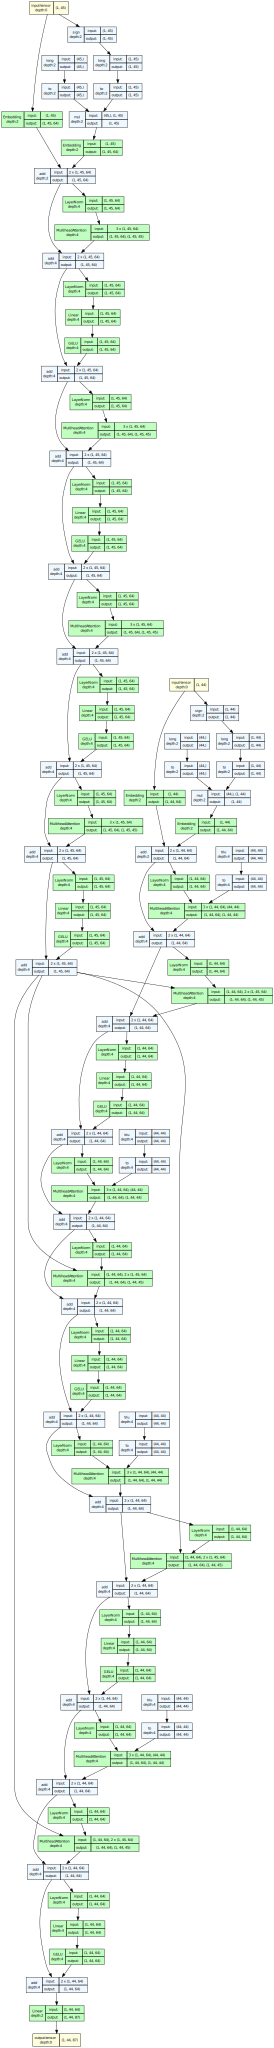

In [133]:
model_graph = draw_graph(enc_dec_net,
                         input_data=[torch.Tensor(enc_x_train[0:1]).long(),
                                     torch.Tensor(dec_x_train[0:1]).long()], 
                         device=device,
                         hide_inner_tensors=True,
                         hide_module_functions=True, 
                         expand_nested=False, 
                         depth=4, 
                         dtypes=[torch.long, torch.long])

model_graph.visual_graph

In [134]:
dec_y_train.shape

In [135]:
enc_dec_net(torch.Tensor(enc_x_train[0:1]).long().to(device), torch.Tensor(dec_x_train[0:1]).long().to(device)).cpu()

tensor([[[ 0.7752, -0.5259,  1.0314,  ...,  0.1646, -0.7816, -2.5010],
         [-1.1898,  1.4827,  1.9202,  ..., -1.4161, -1.3840,  0.6826],
         [ 1.6536,  1.4361, -0.7130,  ..., -0.1181, -0.0350, -0.9561],
         ...,
         [-0.1516,  0.5587,  0.0830,  ..., -0.8168, -1.5102, -0.3160],
         [-0.1553,  0.6597,  0.2222,  ..., -0.7706, -1.4707, -0.3471],
         [-0.0424,  0.5890,  0.1697,  ..., -0.8880, -1.5059, -0.3178]]],
       grad_fn=<ToCopyBackward0>)

In [136]:
batch_size = 128
xy_train = torch.utils.data.DataLoader(list(zip(torch.Tensor(enc_x_train).long(),
                                                torch.Tensor(dec_x_train).long(),
                                                torch.Tensor(dec_y_train).long())), 
                                       shuffle=True, 
                                       batch_size=batch_size, 
                                       num_workers=8)

xy_val = torch.utils.data.DataLoader(list(zip(torch.Tensor(enc_x_val).long(), 
                                              torch.Tensor(dec_x_val).long(),
                                              torch.Tensor(dec_y_val).long())), 
                                     shuffle=False, 
                                     batch_size=batch_size, 
                                     num_workers=8)

/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [137]:
logger = pl.loggers.CSVLogger("lightning_logs", 
                              name="Open_Lab_5",
                              version="demo-0")

In [138]:
trainer = pl.Trainer(logger=logger, max_epochs=300,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=False, 
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [139]:
trainer.validate(enc_dec_net, xy_val)

/opt/conda/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning: Experiment logs directory lightning_logs/Open_Lab_5/demo-0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │   0.021233370527625084    │
│         val_loss          │     4.92318058013916      │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.021233370527625084, 'val_loss': 4.92318058013916}]

In [140]:
trainer.test(enc_dec_net, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │   0.012511806562542915    │
│         test_loss         │     5.009153842926025     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.012511806562542915, 'test_loss': 5.009153842926025}]

In [ ]:
trainer.fit(enc_dec_net, xy_train, xy_val) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | mc_acc   | MulticlassAccuracy | 0     
1 | cce_loss | CrossEntropyLoss   | 0     
2 | enc_net  | EncoderNetwork     | 91.8 K
3 | dec_net  | DecoderNetwork     | 165 K 
------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _releaseLock at 0x7f94f0b43b00>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 
[rank: 0] Received SIGTERM: 15
Bypassing SIGTERM: 15


In [ ]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

In [ ]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))], 
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))], 
         label="Validation")

plt.legend() 
plt.ylabel("CCE Loss") 
plt.xlabel("Epoch") 
plt.show()

In [ ]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_acc"]))], 
         results["train_acc"][np.logical_not(np.isnan(results["train_acc"]))], 
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_acc"]))], 
         results["val_acc"][np.logical_not(np.isnan(results["val_acc"]))], 
         label="Validation")

plt.legend() 
plt.ylabel("Accuracy")
plt.xlabel("Epoch") 
plt.show()

In [ ]:
print("")
print("Validation accuracy:", *["%.8f"%(x) for x in results['val_acc'][np.logical_not(np.isnan(results["val_acc"]))]])
print("")
print("")